In [1]:
import sys 
sys.path.append('../..')

from models import DIFDensityEstimator,SoftmaxWeight,LocationScaleFlow
from targets import Target
from utils.color_visual import *
%load_ext autoreload
%autoreload 2
import torch
import matplotlib.pyplot as plt
import numpy as np
import torch
import matplotlib.gridspec as gridspec
import seaborn as sns
torch.manual_seed(0)
from torch import nn

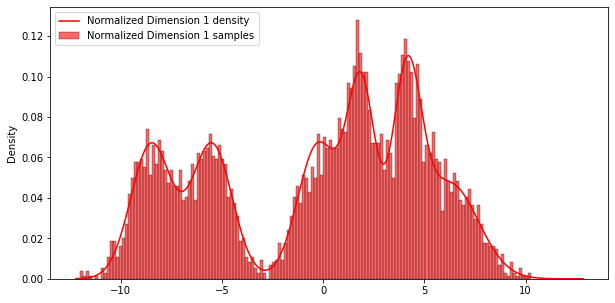

In [2]:
example = "Normalized Dimension 1"
num_samples = 50000
target = Target(example, num_samples)
target.target_visual()
p, target_log_density, target_samples = target.get_target()
num_samples = target_samples.shape[0]

In [3]:
epochs = 500
batch_size = int(num_samples/50)
K = 4
initial_w = SoftmaxWeight(K,p,[3,3])
initial_T = LocationScaleFlow(K,p)
initial_T.m = nn.Parameter(torch.randn([K,p]))
dif = DIFDensityEstimator(target_samples,K)
dif.w = initial_w
dif.T = initial_T
loss_values = dif.train(epochs, batch_size)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [04:38<00:00,  1.79it/s, loss = 2.849678]


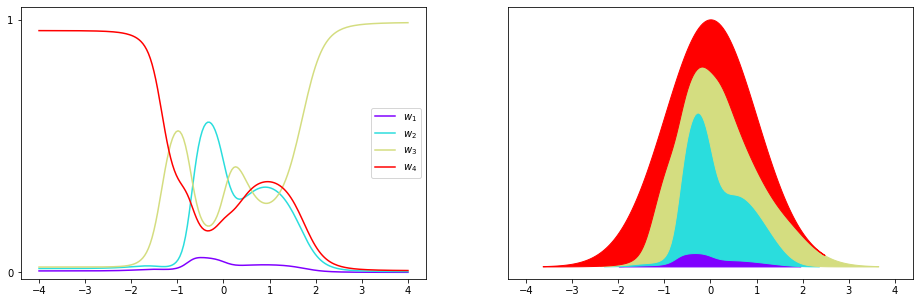

In [4]:
color = plt.cm.rainbow(np.linspace(0,1,K))
tt = torch.linspace(-4,4,200).unsqueeze(-1).unsqueeze(-2).repeat(1,K,1)
prob_w = torch.exp(dif.w.log_prob(tt))[:,0,:].detach()
fig = plt.figure(figsize =(16,5))
ax1 = plt.subplot(1,2,1)
ax1.set_yticks(np.arange(0,2,1))
ax1.set_ylim(bottom = -0.025, top = 1.05)
tt = tt[:,0,0]
cum = 0
for k,c in zip(range(K), color):
    ax1.plot(tt.cpu(), prob_w[:,k].cpu(), label = r'$w_'+str(k+1)+'$', color = c)
ax1.legend()

ax2 = plt.subplot(1,2,2, sharex = ax1)
ax2.tick_params(left=False,bottom=True,labelleft=False,labelbottom=True)
cum = torch.zeros([tt.shape[0]])
for k, c in zip(range(K), color):
    ancien_cum = cum
    cum = cum + torch.exp(dif.reference.log_density(tt.unsqueeze(-1)))*prob_w[:,k] 
    ax2.fill_between(tt.cpu(), ancien_cum.cpu().detach().numpy(), cum.cpu().detach().numpy(), where = torch.abs(ancien_cum.cpu() - cum.cpu())>5e-4, color=c)

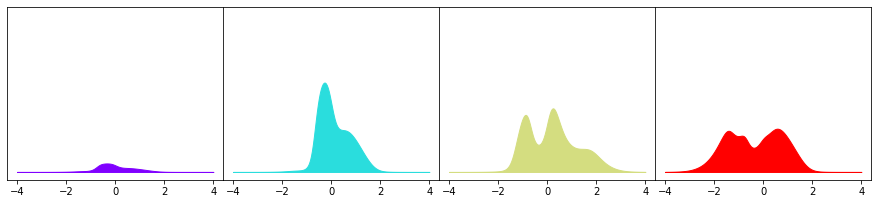

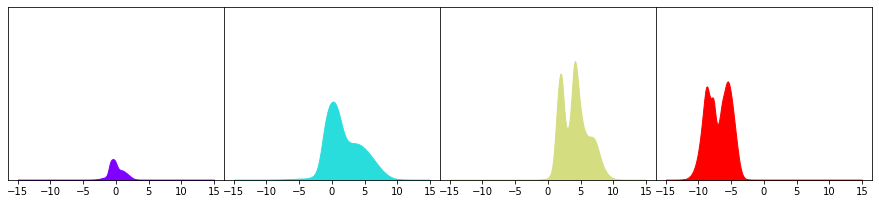

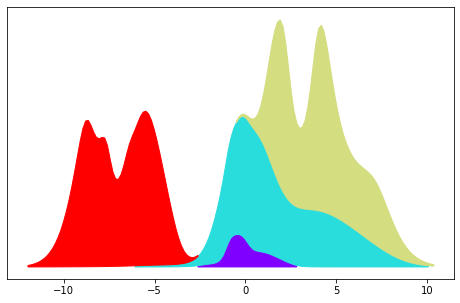

In [5]:
tt_z = torch.linspace(-4,4,200).unsqueeze(-1).unsqueeze(-2).repeat(1,K,1)
prob_w = torch.exp(dif.w.log_prob(tt_z))[:,0,:].detach()
fig = plt.figure(figsize = (15,3))
tt_z = tt_z[:,0,0]
for k,c in zip(range(K),color):
    ax = fig.add_axes([.8*k/K,.1 , .8/K,.8] ,yticklabels=[], sharey = ax2)
    ax.tick_params(left=False,bottom=True,labelleft=False,labelbottom=True)
    part =torch.exp(dif.reference.log_density(tt_z.unsqueeze(-1)))*prob_w[:,k] 
    ax.fill_between(tt_z.cpu(), part.cpu().detach().numpy(), color = c  )
fig = plt.figure(figsize = (15,3))
tt_x = torch.linspace(-15,15,200).unsqueeze(-1)
z = dif.T.forward(tt_x)
prob = torch.diagonal(torch.exp(dif.w.log_prob(z)),0, -2, -1)
ref = torch.exp(dif.reference.log_density(z))
det = torch.exp(dif.T.log_det_J(tt))
total = prob * ref * det
for k,c in zip(range(K),color):
    ax = fig.add_axes([.8*k/K,.1 , .8/K,.8] ,yticklabels=[], ylim=[0,.12] )
    ax.tick_params(left=False,bottom=True,labelleft=False,labelbottom=True)
    ax.fill_between(tt_x.squeeze(-1).cpu(), total[:,k].cpu().detach().numpy(), color = c  )  
plt.plot()
cum = torch.zeros([tt_x.shape[0]])
fig = plt.figure(figsize = (8,5))
plt.tick_params(left=False,bottom=True,labelleft=False,labelbottom=True)
for k,c in zip(range(K), color):
    ancien_cum = cum
    cum = cum + total[:,k]
    plt.fill_between(tt_x.squeeze(-1).cpu(), ancien_cum.cpu().detach().numpy(), cum.cpu().detach().numpy(), where = torch.abs(ancien_cum.cpu() - cum.cpu())>5e-4, color=c)

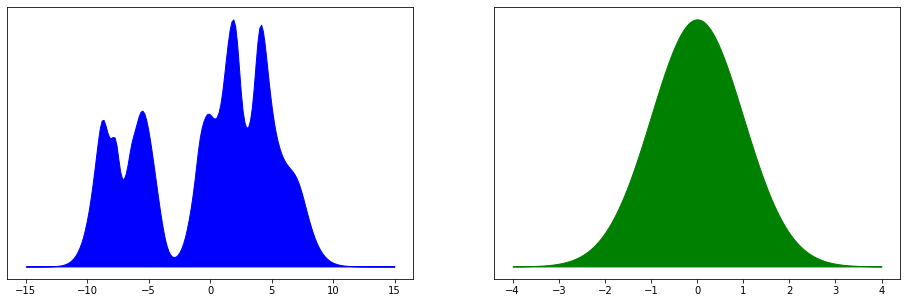

In [6]:
density_x = torch.exp(dif.log_density(tt_x))
density_z = torch.exp(dif.reference.log_density(tt_z.unsqueeze(-1)))
fig = plt.figure(figsize =(16,5))
ax1 = plt.subplot(1,2,1)
ax1.fill_between(tt_x.cpu().squeeze(-1).numpy(), density_x.cpu().detach().numpy(), color = blue_color)
ax1.tick_params(left=False,bottom=True,labelleft=False,labelbottom=True)
ax2 = plt.subplot(1,2,2)
ax2.tick_params(left=False,bottom=True,labelleft=False,labelbottom=True)
ax2.fill_between(tt_z.cpu().squeeze(-1).numpy(), density_z.cpu().detach().numpy(), color = green_color)